In [1]:
#import
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [2]:
#import Pytorch Lib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torch.optim as optim

In [3]:
#matplotlib setting
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['axes.grid'] = True 

In [4]:
pcr_df = pd.read_csv('./농도테스트(201111).csv')


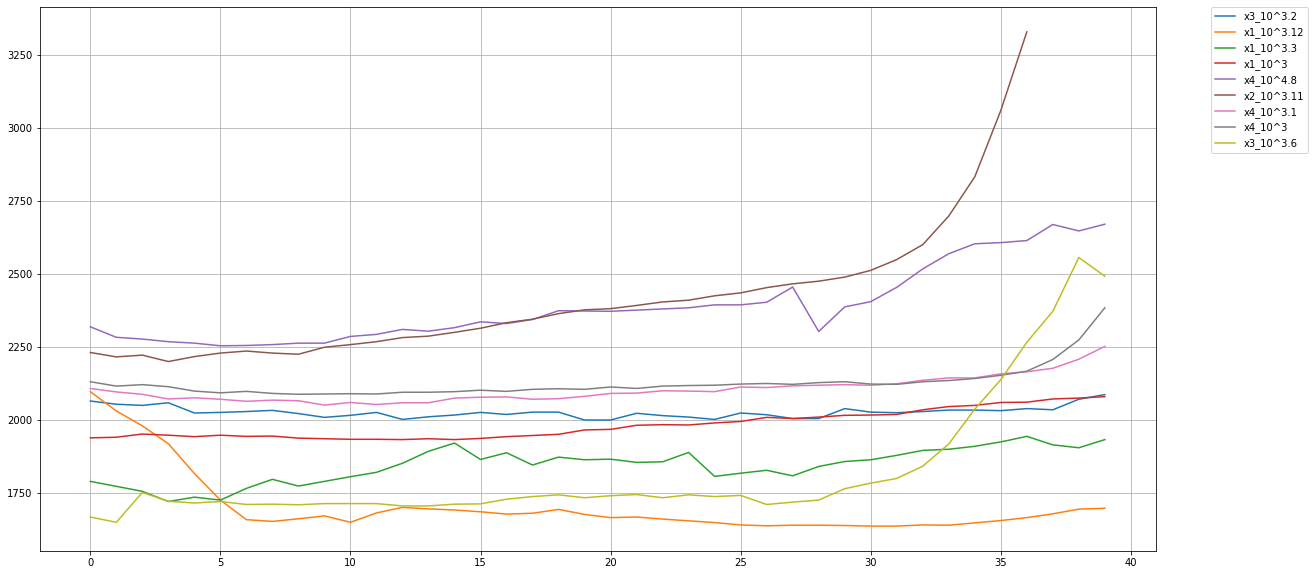

In [5]:
#drop Neg data
pcr_df = pcr_df.drop(columns=['X1_Neg', 'X2_Neg', 'X3_Neg', 'X4_Neg'])

#drop 10^6 data
pcr_df = pcr_df.drop(columns=['x1_10^6', 'x1_10^6.1',	'x1_10^6.2',	'x1_10^6.3',	'x1_10^6.4',	'x1_10^6.5'
                              ,	'x2_10^6',	'x2_10^6.1',	'x2_10^6.2',	'x2_10^6.3',	'x2_10^6.4'
                              ,	'x3_10^6',	'x3_10^6.1',	'x3_10^6.2',	'x3_10^6.3',	'x3_10^6.4'
                              ,	'x4_10^6',	'x4_10^6.1',	'x4_10^6.2',	'x4_10^6.3'])


#drop weird data
sns.lineplot(data=pcr_df[['x3_10^3.2', 'x1_10^3.12', 'x1_10^3.3', 'x1_10^3', 'x4_10^4.8','x2_10^3.11', 'x4_10^3.1', 'x4_10^3', 'x3_10^3.6']], dashes=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

pcr_df = pcr_df.drop(columns=['x3_10^3.2', 'x1_10^3.12', 'x1_10^3.3', 'x1_10^3',  'x4_10^4.8','x2_10^3.11', 'x4_10^3.1', 'x4_10^3', 'x3_10^3.6'])


In [6]:
pcr_5_df = pd.DataFrame()
pcr_4_df = pd.DataFrame()
pcr_3_df = pd.DataFrame()

#Seperate each concentration(5, 4, 3)
for col in pcr_df.columns:
    if col[6] == '5':
        pcr_5_df = pcr_5_df.append(pcr_df[col])
    elif col[6] == '4':
        pcr_4_df = pcr_4_df.append(pcr_df[col])
    elif col[6] == '3':
        pcr_3_df = pcr_3_df.append(pcr_df[col])


print(f'10^5:{pcr_5_df.shape[0], pcr_5_df.shape[1]}, 10^4:{pcr_4_df.shape[0], pcr_4_df.shape[1]}, 10^3:{pcr_3_df.shape[0], pcr_3_df.shape[1]}')


10^5:(24, 40), 10^4:(71, 40), 10^3:(48, 40)


In [7]:
pcr_df = pcr_df.T


In [8]:
#Get target
target_arr = []
target_3 = []
target_4 = []
target_5 = []

for index, row in pcr_df.iterrows():
    if index[6] == '5':
        target_arr.append(27.94744)
        target_5.append(27.94744)
    elif index[6] == '4':
        target_arr.append(31.09441)
        target_4.append(31.09441)
    elif index[6] == '3':
        target_arr.append(33.58142)
        target_3.append(33.58142)

target_arr = np.array(target_arr)
target_3 = np.array(target_3)
target_4 = np.array(target_4)
target_5 = np.array(target_5)

print(target_arr[95:])

[33.58142 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142
 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142
 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142
 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142
 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142
 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142 33.58142]


In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Cuda Activated")
else:
    device = torch.device("cpu")
    print("Cuda Not Activated")

Cuda Not Activated


In [10]:
pcr_bf_df = pcr_df.T
pcr_bf_df = pcr_bf_df - pcr_bf_df.loc[:10].mean(axis=0)

data = torch.tensor(pcr_bf_df.values.astype(np.float32), dtype=torch.float32).to(device)
data = torch.reshape(data, (-1, 1, 40))
target = torch.tensor(target_arr, dtype=torch.float32).to(device)

if torch.cuda.is_available():
    data, target = data.cuda(), target.cuda()

In [11]:
#Definition of model
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1d_layer = nn.Sequential(
            nn.Conv1d(1, 16, 3), #38
            nn.ReLU(),
            
            nn.Conv1d(16, 16, 3), #36
            nn.ReLU(),
            
            nn.MaxPool1d(2), #18
            
            nn.Conv1d(16, 32, 3), #16
            nn.ReLU(),
            
            nn.Conv1d(32, 32, 3), #14
            nn.ReLU(),
            
            nn.MaxPool1d(2), #7
            
            nn.Conv1d(32, 48, 3), #5
            nn.ReLU(),
            
            nn.Conv1d(48, 48, 3), #3
            nn.ReLU(),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(144, 100),
            nn.ReLU(),
            
            nn.Linear(100, 1),
        )
        
    def forward(self, x):
        x = self.conv1d_layer(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.fc_layer(x)

        return x

In [12]:
from torch.optim import Adam
from torch.nn import L1Loss, MSELoss

loss_func = L1Loss()

In [13]:
TOTAL_DATA_SIZE = len(data)
BATCH_SIZE = 35
TRAIN_SIZE = int(BATCH_SIZE/5 * 4)
TEST_SIZE = int(BATCH_SIZE/5)
ITER_NUM = 500
BATCH_ITER_NUM = 500
LEARNING_RATE = 0.0001
result_list=[]; [result_list.append([]) for x in range(len(data))]
print()

In [14]:

for _iter in range(1, ITER_NUM):
        
    suffled_index = np.random.permutation(TOTAL_DATA_SIZE)[:BATCH_SIZE]
    batch_X  = data[suffled_index]
    batch_y  = target[suffled_index]
    
    train_data, test_data = torch.split(batch_X, [TRAIN_SIZE, TEST_SIZE], dim=0)
    train_target, test_target = torch.split(batch_y, [TRAIN_SIZE, TEST_SIZE], dim=0)
    

  #set model parameters & optimizer
    model = Net()
    if torch.cuda.is_available():
        model.cuda()
    optimizer = Adam(model.parameters(), lr = 0.0001)
  
    train_loss = 0.0
    #######################
    #     Train Start     #
    #######################
    model.train()
    for batch_iter in range(1, BATCH_ITER_NUM+1):
        optimizer.zero_grad()
        output = model(train_data)
        loss = loss_func(output, train_target.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss = loss
    #######################################################
    
    #######################
    #     Test Start      #
    #######################
    model.eval()
    output = model(test_data)
    loss = loss_func(output, test_target.view(-1, 1))
    output = output.view(-1).tolist()
    print(f'{_iter} train_loss:{train_loss}, test_loss:{loss}')
    
    for i, val in enumerate(suffled_index[-7:]):
        result_list[val].append(output[i])

1 train_loss:4.865158557891846, test_loss:8.767305374145508
2 train_loss:3.674569845199585, test_loss:7.974379539489746
3 train_loss:4.064865589141846, test_loss:14.886008262634277
4 train_loss:3.9885785579681396, test_loss:7.223402500152588
5 train_loss:3.898035764694214, test_loss:17.622098922729492
6 train_loss:5.948879718780518, test_loss:19.25259017944336
7 train_loss:5.49888277053833, test_loss:8.83275318145752
8 train_loss:3.577543020248413, test_loss:7.4881744384765625
9 train_loss:5.676728248596191, test_loss:9.8860445022583
10 train_loss:4.10514497756958, test_loss:9.868739128112793
11 train_loss:2.083953380584717, test_loss:10.044364929199219
12 train_loss:4.310451030731201, test_loss:10.509026527404785
13 train_loss:5.161949157714844, test_loss:11.34963321685791
14 train_loss:4.940408229827881, test_loss:7.785910129547119
15 train_loss:4.189590930938721, test_loss:11.899630546569824
16 train_loss:5.089580535888672, test_loss:9.563928604125977
17 train_loss:5.109442234039307

264 train_loss:3.551173686981201, test_loss:6.693215370178223
265 train_loss:4.979968547821045, test_loss:9.427345275878906
266 train_loss:2.412778615951538, test_loss:7.507451057434082
267 train_loss:3.6417574882507324, test_loss:11.647859573364258
268 train_loss:4.094628810882568, test_loss:8.370833396911621
269 train_loss:5.654648780822754, test_loss:10.382051467895508
270 train_loss:3.9993183612823486, test_loss:7.814174652099609
271 train_loss:3.8777499198913574, test_loss:6.091341972351074
272 train_loss:5.94602108001709, test_loss:11.91441822052002
273 train_loss:4.897627830505371, test_loss:7.680851936340332
274 train_loss:5.436442852020264, test_loss:5.32605504989624
275 train_loss:5.720320224761963, test_loss:18.5283260345459
276 train_loss:6.153365612030029, test_loss:11.20360279083252
277 train_loss:4.782531261444092, test_loss:11.850908279418945
278 train_loss:2.99332857131958, test_loss:12.611862182617188
279 train_loss:3.0270497798919678, test_loss:3.967813491821289
280 

In [15]:
result_len = [len(result) for result in result_list]
final_results = []

for result in result_list:
    final_results.append(np.array(result).mean())
print(final_results)

[4.0423645462308615, 3.059783444404602, 6.359146318128032, 7.621599038441976, 2.2328628358386813, 4.4440311892279265, 6.3306206994586525, 3.639786892467075, 3.7211996225210338, 4.720653401480781, 6.585524658362071, 3.9719972885571995, 3.238712999128526, 7.5647586308992825, 8.340742233821324, 6.745405717329546, 6.981403350830078, 8.716237344239888, 10.776835140429045, 11.423041037150792, 13.758910260881697, 17.330488664132577, 17.566786185554836, 19.44770692742389, 18.380790961416142, 16.483772791348972, 23.667023258824504, 23.813737288765285, 22.625797878612172, 20.348725526229195, 22.510701055112094, 31.495764323643275, 20.701437143179085, 29.426134983698528, 29.717838460748847, 23.12921530859811, 25.958089192708332, 28.603820627385918, 38.098637124766476, 24.291194803574506, 30.429336176978218, 33.61313343048096, 28.97141772303088, 24.27381467819214, 35.0632542292277, 36.34551384335472, 27.46540911992391, 32.60486293661183, 37.666319473930024, 37.0127010345459, 20.567243977596885, 31

In [16]:
_dict = {'target' : target_arr, 'output': final_results}

pd_result = pd.DataFrame(_dict)

display(pd_result[95:] < 29)

,target,output
95,False,False
96,False,False
97,False,False
98,False,False
99,False,False
100,False,False
101,False,True
102,False,True
103,False,False
104,False,False


In [17]:
display(pd_result < 26)

,target,output
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True
...,...,...
138,False,False
139,False,False
140,False,False
141,False,False


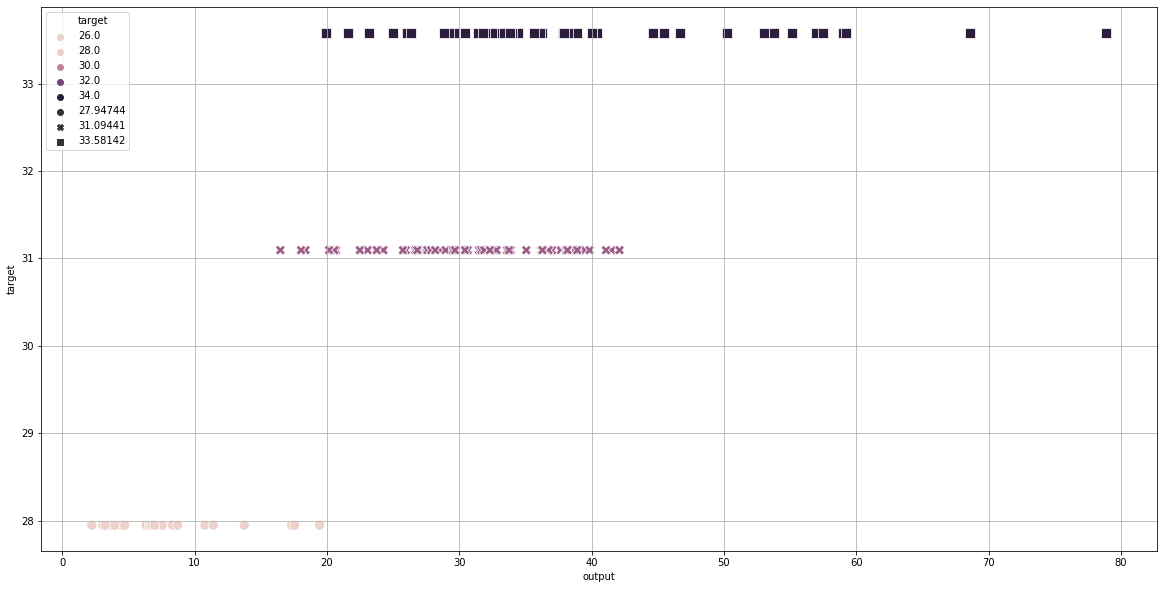

             output
target             
27.94744   7.859192
31.09441  30.464799
33.58142  38.890376
             output
target             
27.94744   4.871138
31.09441   6.496418
33.58142  12.436988


In [18]:
pd_result_gt = pd_result.groupby('target')
sns.scatterplot(x='output', 
                y='target', 
                hue='target', # different colors by group
                style='target', # different shapes by group
                s=100, # marker size
                data=pd_result)

plt.show()

print(pd_result_gt.mean())
print(pd_result_gt.std())

11
37


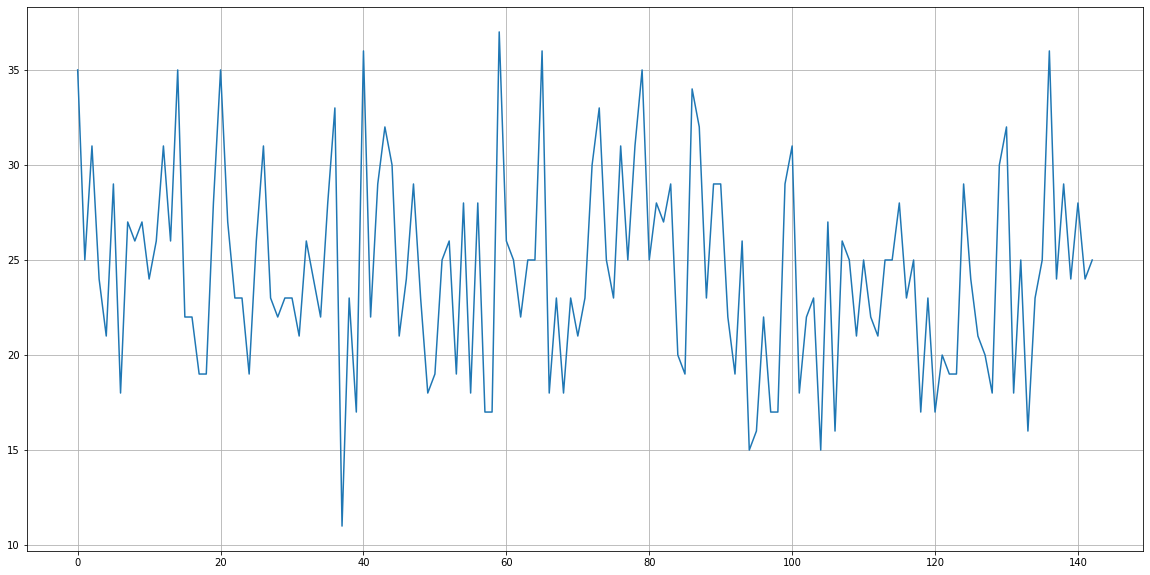

In [19]:
plt.plot(result_len)

print(min(result_len))
print(max(result_len))

In [20]:
print(pcr_df)
pcr_df = pcr_df.T
pcr_lam_df = pcr_df - pcr_df.loc[:10].mean(axis=0)


              0     1     2     3     4     5     6     7     8     9   ...  \
X1_10^5     2091  2077  2068  2056  2053  2037  2039  2033  2028  2025  ...   
X1_10^5.1   2105  2094  2085  2065  2056  2051  2058  2066  2062  2061  ...   
X1_10^5.2   1953  1939  1916  1908  1895  1883  1881  1876  1872  1871  ...   
X1_10^5.3   1811  1810  1806  1797  1798  1795  1792  1787  1782  1780  ...   
X1_10^5.4   2048  2039  2022  2022  2015  2013  2007  2010  2012  2012  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
x4_10^3.9   2368  2352  2327  2315  2313  2299  2285  2285  2276  2277  ...   
x4_10^3.10  2754  2750  2743  2728  2712  2691  2701  2710  2727  2730  ...   
x4_10^3.11  2598  2567  2550  2540  2539  2532  2523  2515  2514  2512  ...   
x4_10^3.12  2913  2851  2825  2798  2776  2756  2739  2727  2722  2720  ...   
x4_10^3.13  2494  2484  2477  2471  2445  2440  2434  2430  2417  2418  ...   

              30    31    32    33    34    35    3

In [21]:
pcr_loglam_df = np.log(pcr_lam_df)

C:\Users\butte\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\butte\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [22]:
#Function to calculate Ct
def calcCt(lDb, lth):
    ct = np.zeros(len(lDb.columns))
    ic = 0
    
    lDb_over10 = lDb[10:]#baseline은 제외
    
    for c in lDb.columns:
        tmp=lDb_over10.loc[lDb_over10[c]>lth]
        
        if tmp.empty:
            ct[ic]=-1
        else:
            id = tmp[c].index[0]
            rv = lDb[c].loc[id]
            lv = lDb[c].loc[id-1]
            dv = rv-lv
            ct[ic] = id - (rv-lth)/dv
        ic += 1
        
    return ct

In [23]:
th = 5.5

In [24]:
ct = calcCt(pcr_loglam_df, th)
print(ct)

[27.17439803 27.79433251 29.55887094 28.99751921 30.65109102 25.34381239
 27.45311574 26.74772571 28.1071148  28.55693335 28.61275172 25.02474139
 26.69285358 27.72544829 29.25616909 29.35934896 30.22234858 25.74124036
 27.11304847 27.5320819  28.92971801 28.78300354 29.42516512 25.93576736
 31.43947693 34.0612038  31.46917808 34.01458764 33.11659479 28.50516669
 29.39038436 30.62547157 31.1606151  30.77037075 30.84692381 32.07145404
 31.86912896 30.83000516 31.12491234 29.73470252 31.06848801 30.66446057
 30.40172103 32.7890163  31.61927835 31.67552567 33.78912006 27.94923732
 28.40975427 29.55348642 30.5364776  29.32402322 29.95900873 30.44008393
 31.12801594 29.66327656 29.75295492 30.82058026 29.87614584 28.85187239
 31.74715299 33.071385   33.75076967 33.7423092  33.80481732 28.60939969
 29.39203572 30.65469667 31.01417465 31.42086337 31.03859859 32.528764
 30.51154604 31.86184542 32.08910688 31.46922531 31.05658892 31.77880599
 31.03806879 32.42959446 32.87114002 33.89103932 32.5

In [25]:
target_arr55 = []

for index, row in pcr_df.T.iterrows():
    if index[6] == '5':
        target_arr55.append(27.74744)
    elif index[6] == '4':
        target_arr55.append(30.9)
    elif index[6] == '3':
        target_arr55.append(33.38142)
        
target_arr55 = np.array(target_arr55)


In [26]:
_dict = {'target' : np.concatenate([target_arr, target_arr55], axis=0),
         'output': np.concatenate([final_results, ct], axis=0)}

pd_result = pd.DataFrame(_dict)

display(pd_result)

,target,output
0,27.94744,4.042365
1,27.94744,3.059783
2,27.94744,6.359146
3,27.94744,7.621599
4,27.94744,2.232863
...,...,...
281,33.38142,31.286211
282,33.38142,34.917963
283,33.38142,33.465267
284,33.38142,34.020090


In [27]:
pd_result

,target,output
0,27.94744,4.042365
1,27.94744,3.059783
2,27.94744,6.359146
3,27.94744,7.621599
4,27.94744,2.232863
...,...,...
281,33.38142,31.286211
282,33.38142,34.917963
283,33.38142,33.465267
284,33.38142,34.020090


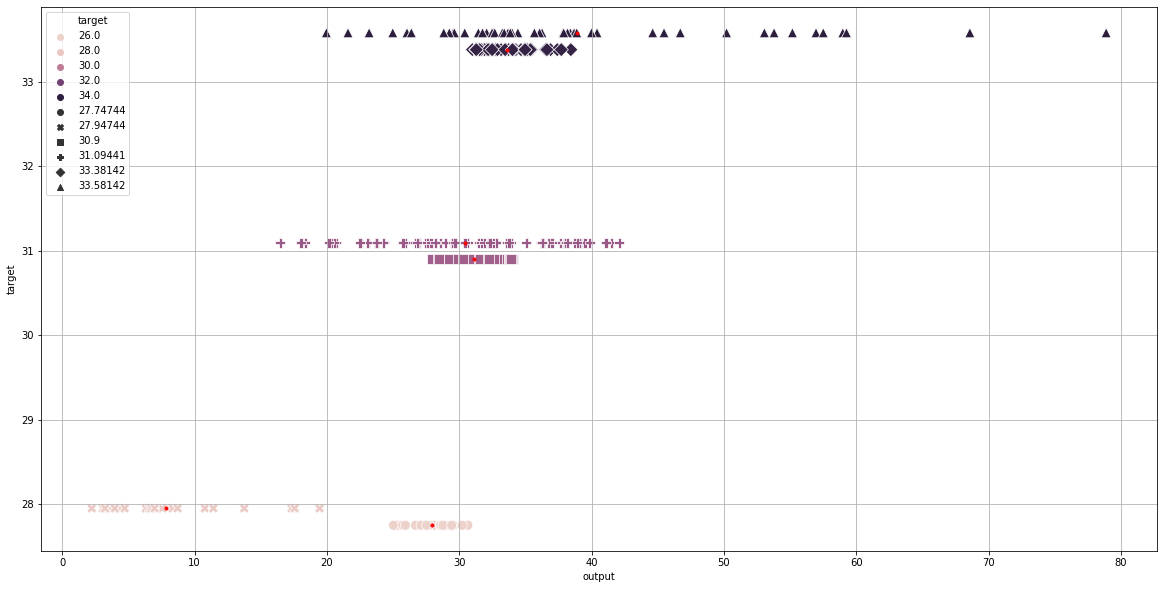

             output
target             
27.74744  27.947442
27.94744   7.859192
30.90000  31.094411
31.09441  30.464799
33.38142  33.617814
33.58142  38.890376
             output
target             
27.74744   1.526701
27.94744   4.871138
30.90000   1.472649
31.09441   6.496418
33.38142   1.919485
33.58142  12.436988


In [28]:

pd_result_gt = pd_result.groupby('target')
sns.scatterplot(x='output', 
                y='target', 
                hue='target', # different colors by group
                style='target', # different shapes by group
                s=100, # marker size
                data=pd_result)
plt.plot(pd_result_gt['output'].mean(),pd_result_gt['target'].mean(), '.', color='r')
plt.show()

print(pd_result_gt.mean())
print(pd_result_gt.std())


In [29]:
# sum of std
print('sum of std')
print('Log Threshold')
print(np.sum(np.array(pd_result_gt.std())[::2]))

print('Learning')
print(np.sum(np.array(pd_result_gt.std())[1::2]))

# # std of mean
print('\n\n\nstd of mean')
print('Log Threshold')
print(np.std(np.array(pd_result_gt.mean())[::2]))

print('Learning')
print(np.std(np.array(pd_result_gt.mean())[1::2]))

sum of std
Log Threshold
4.9188352677879585
Learning
23.804544329515522



std of mean
Log Threshold
2.3195810959524583
Learning
13.101900841074812


In [30]:
logT_index = [27.74744, 30.9, 33.38142]
logT_df = pd.DataFrame({'target' : target_arr55, 'output': ct})

logT_mean = logT_df['output'].mean()

logT_means = []
logT_vars = []

logT_between_varience = 0
logT_within_varience = 0
for idx in logT_index:
    target = np.array(logT_df[logT_df['target'] == idx].values)
    mean = np.mean(target)
    var = target.var(ddof=1)
    logT_means.append(mean)
    logT_vars.append(var)
    
logT_means = np.array(logT_means)
logT_between_varience = np.sum(np.power(logT_means - logT_mean, 2)) / 6
logT_within_varience = np.sum(logT_vars) / len(logT_vars)
    

print('\nLog Threshold')
print('logT anova :', logT_between_varience / logT_within_varience)


learning_index = [27.94744, 31.09441, 33.58142]
learning_df = pd.DataFrame({'target' : target_arr, 'output': final_results})

learning_mean = learning_df['output'].mean()
learning_means = []
learning_vars = []

learning_between_varience = 0
learning_within_varience = 0

for idx in learning_index:
    target = np.array(learning_df[learning_df['target'] == idx].values)
    mean = np.mean(target)
    var = target.var(ddof=1)
    learning_means.append(mean)
    learning_vars.append(var)
    
learning_means = np.array(learning_means)
learning_between_varience = np.sum(np.power(learning_means - learning_mean, 2)) / 6
learning_within_varience = np.sum(learning_vars) / len(learning_vars)
print('\nLearning')
print('learning anova :',learning_between_varience / learning_within_varience)


Log Threshold
logT anova : 2.1160216825484777

Learning
learning anova : 0.41370872635973616
